In [1]:
# ------------------------------
# Step 1: Import Required Libraries
# ------------------------------
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

In [2]:
# ------------------------------
# Step 2: Fetch and Prepare Stock Data
# ------------------------------

# Set the date range
start_date = '2003-01-01'
end_date = '2021-12-31'

# Fetch data for Microsoft (MSFT)
msft = yf.Ticker('MSFT')
stock_data_msft = msft.history(start=start_date, end=end_date)

In [3]:
# Check if the stock data has multi-level columns
if isinstance(stock_data_msft.columns, pd.MultiIndex):
    print("Multi-level columns detected in stock data. Flattening columns...")
    stock_data_msft.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in stock_data_msft.columns]
else:
    print("Single-level columns detected in stock data.")

Single-level columns detected in stock data.


In [4]:
# Remove the timezone from the index
stock_data_msft.index = stock_data_msft.index.tz_localize(None)

In [5]:
# Reset index to make 'Date' a regular column
stock_data_msft.reset_index(inplace=True)

# Convert 'Date' column to datetime
stock_data_msft['Date'] = pd.to_datetime(stock_data_msft['Date'])

14:59:35 - cmdstanpy - INFO - Chain [1] start processing
14:59:39 - cmdstanpy - INFO - Chain [1] done processing


Base Model MSE: 38262.01253122273
Base Model MAE: 147.05534520433318


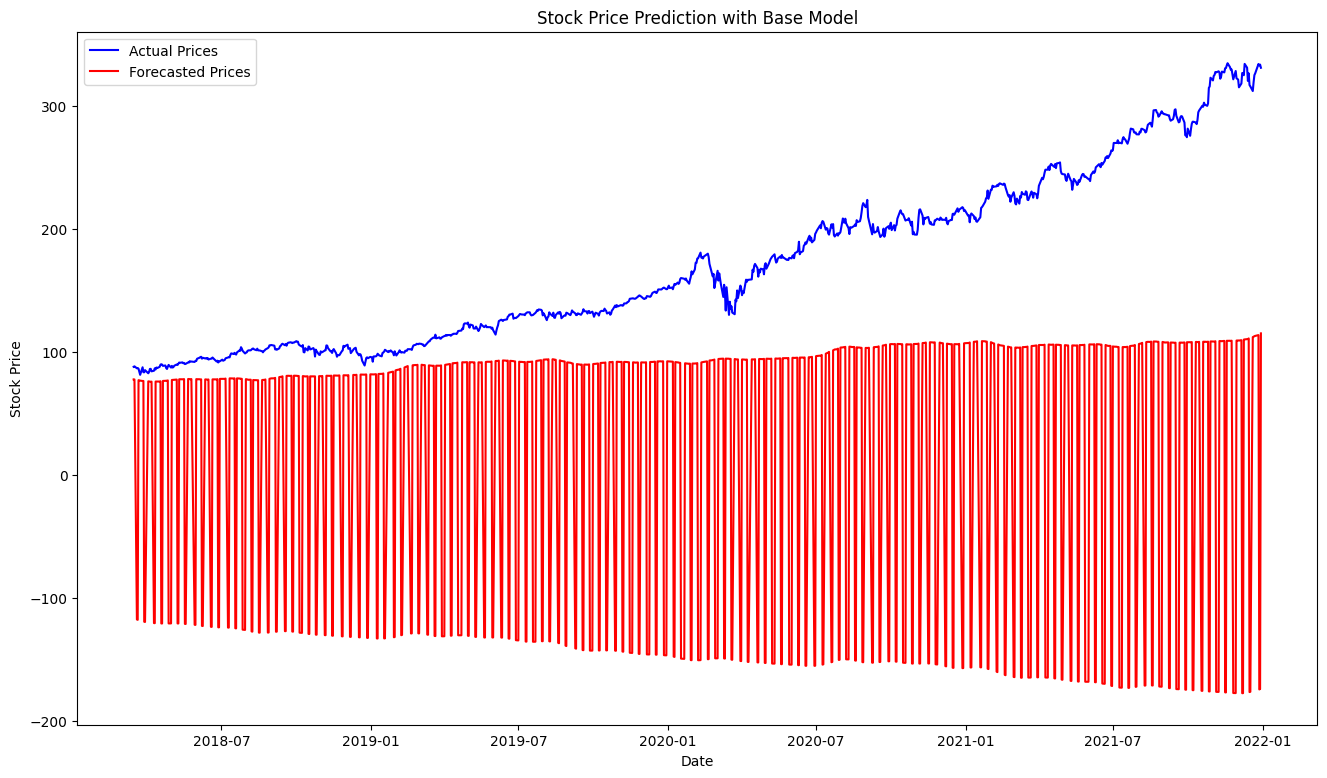

In [7]:
# ------------------------------
# Step 3: Simple Prophet Model (Base Model)
# ------------------------------

# Prepare data for Prophet without additional features
simple_data = stock_data_msft[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Split into train and test
train_size = int(len(simple_data) * 0.8)
train_data = simple_data.iloc[:train_size]
test_data = simple_data.iloc[train_size:]

# Initialize Prophet
model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.05)

# Fit the model
model.fit(train_data)

# Forecasting
future = model.make_future_dataframe(periods=len(test_data))
forecast = model.predict(future)

# Evaluate performance
mse = mean_squared_error(test_data['y'], forecast['yhat'][-len(test_data):])
mae = mean_absolute_error(test_data['y'], forecast['yhat'][-len(test_data):])

print(f"Base Model MSE: {mse}")
print(f"Base Model MAE: {mae}")

# Visualization
plt.figure(figsize=(16, 9))
plt.plot(test_data['ds'], test_data['y'], label='Actual Prices', color='blue')
plt.plot(test_data['ds'], forecast['yhat'][-len(test_data):], label='Forecasted Prices', color='red')
plt.title("Stock Price Prediction with Base Model")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
Dividends         0
Stock Splits      0
publish_date      0
headline_text     0
compound_score    0
positive          0
neutral           0
negative          0
dtype: int64
ds                     0
y                      0
compound_score         0
compound_score_lag1    0
compound_score_lag2    0
dtype: int64


15:04:55 - cmdstanpy - INFO - Chain [1] start processing
15:05:44 - cmdstanpy - INFO - Chain [1] done processing


MSE with Sentiment: 18266.48084871151
MAE with Sentiment: 82.47154744116648


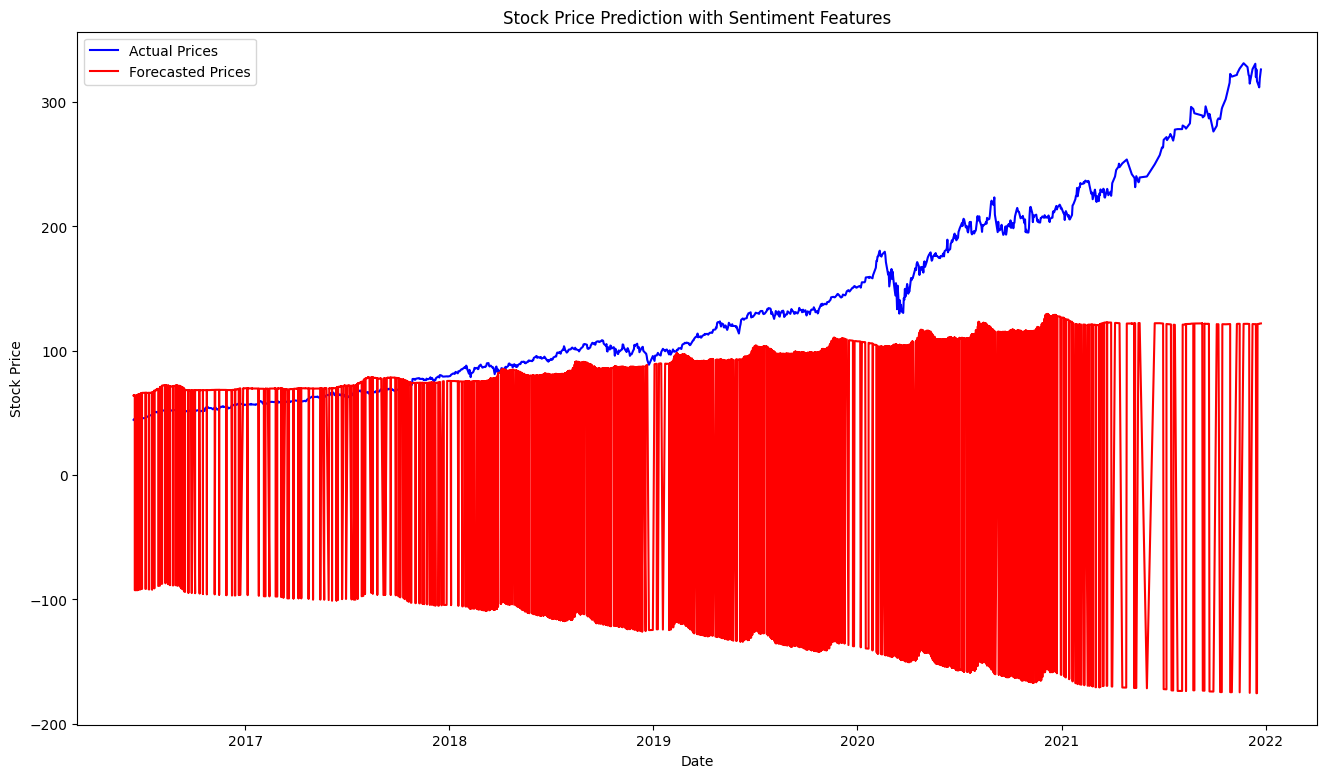

In [11]:
# ------------------------------
# Step 4: Load and Merge Stock and News Data
# ------------------------------
news_data = pd.read_csv('cleaned_business_news_with_vader.csv')
news_data['publish_date'] = pd.to_datetime(news_data['publish_date'], errors='coerce')

# Ensure there are no NaN values in compound_score
news_data['compound_score'] = news_data['compound_score'].fillna(0)

# Merge stock data and news data
merged_data = pd.merge(stock_data_msft, news_data, left_on='Date', right_on='publish_date', how='inner')

# Check for any missing values after merging
print(merged_data.isnull().sum())  # This will show the missing values in all columns

# Add lagged sentiment features
merged_data['compound_score_lag1'] = merged_data['compound_score'].shift(1)
merged_data['compound_score_lag2'] = merged_data['compound_score'].shift(2)

# Fill NaN values in lagged features
merged_data[['compound_score_lag1', 'compound_score_lag2']] = merged_data[['compound_score_lag1', 'compound_score_lag2']].fillna(0)

# Ensure no NaN values in any of the regressor columns
merged_data[['compound_score', 'compound_score_lag1', 'compound_score_lag2']] = merged_data[['compound_score', 'compound_score_lag1', 'compound_score_lag2']].fillna(0)

# Prepare the data for Prophet
prophet_data = merged_data[['Date', 'Close', 'compound_score', 'compound_score_lag1', 'compound_score_lag2']].rename(
    columns={'Date': 'ds', 'Close': 'y'}
)

# Check again for NaN values
print(prophet_data.isnull().sum())  # Make sure no missing values

# Split into train and test
train_size = int(len(prophet_data) * 0.8)
train_data = prophet_data.iloc[:train_size]
test_data = prophet_data.iloc[train_size:]

# ------------------------------
# Step 5: Prophet Model with Sentiment Features
# ------------------------------
# Initialize Prophet model with sentiment features
model_with_sentiment = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.05)

# Add sentiment as regressors
model_with_sentiment.add_regressor('compound_score')
model_with_sentiment.add_regressor('compound_score_lag1')
model_with_sentiment.add_regressor('compound_score_lag2')

# Fit the model
model_with_sentiment.fit(train_data)

# Forecasting
future = model_with_sentiment.make_future_dataframe(periods=len(test_data))
future = pd.merge(future, prophet_data[['ds', 'compound_score', 'compound_score_lag1', 'compound_score_lag2']], on='ds', how='left')

# Ensure there are no NaN values in the 'future' dataframe
future[['compound_score', 'compound_score_lag1', 'compound_score_lag2']] = future[['compound_score', 'compound_score_lag1', 'compound_score_lag2']].fillna(0)

forecast = model_with_sentiment.predict(future)

# Evaluate performance
mse_with_sentiment = mean_squared_error(test_data['y'], forecast['yhat'][-len(test_data):])
mae_with_sentiment = mean_absolute_error(test_data['y'], forecast['yhat'][-len(test_data):])

print(f"MSE with Sentiment: {mse_with_sentiment}")
print(f"MAE with Sentiment: {mae_with_sentiment}")

# Visualization
plt.figure(figsize=(16, 9))
plt.plot(test_data['ds'], test_data['y'], label='Actual Prices', color='blue')
plt.plot(test_data['ds'], forecast['yhat'][-len(test_data):], label='Forecasted Prices', color='red')
plt.title("Stock Price Prediction with Sentiment Features")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

15:06:31 - cmdstanpy - INFO - Chain [1] start processing
15:07:16 - cmdstanpy - INFO - Chain [1] done processing


Tuned MSE: 15826.379370395707
Tuned MAE: 77.89285412285514


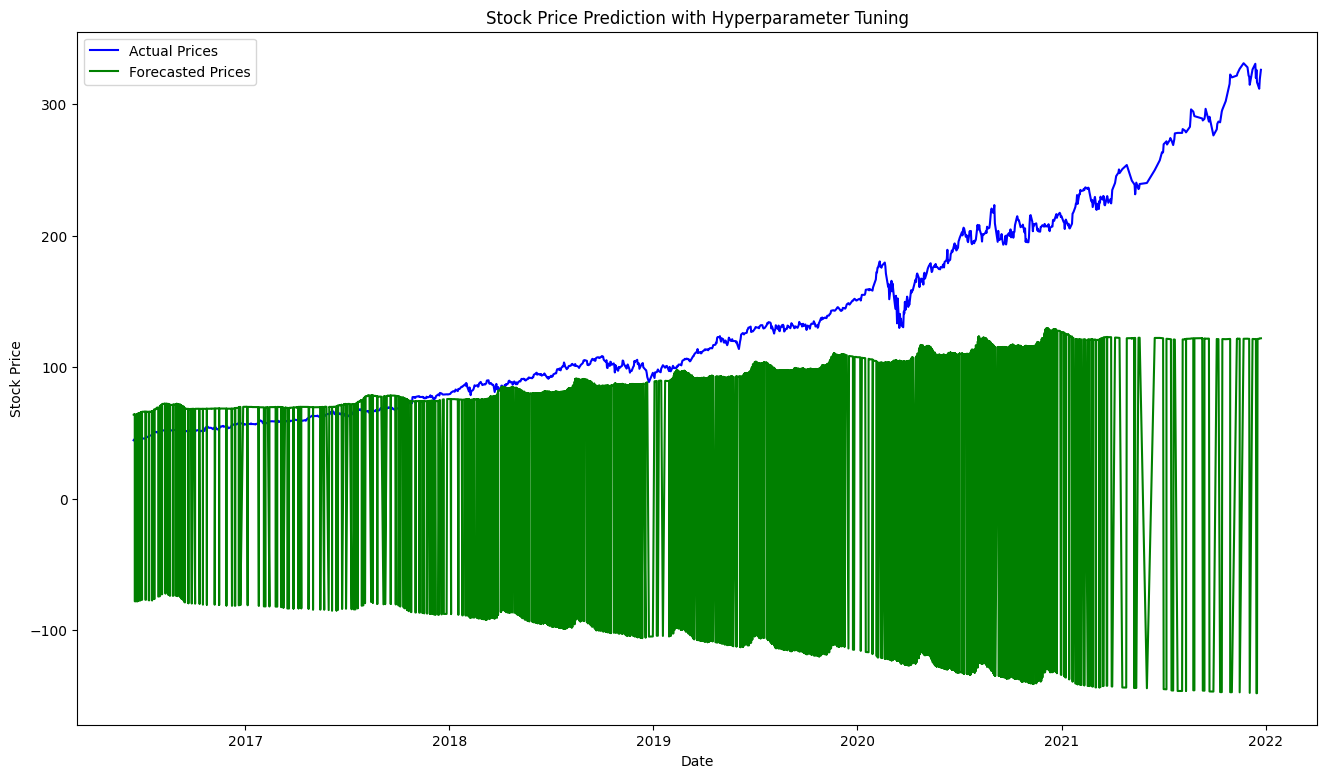

In [12]:
# ------------------------------
# Step 6: Hyperparameter Tuning
# ------------------------------

# Tune the Prophet model
model_tuned = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.1, seasonality_prior_scale=10)

# Fit the tuned model with sentiment
model_tuned.fit(train_data)

# Forecasting
forecast_tuned = model_tuned.predict(future)

# Evaluate performance
mse_tuned = mean_squared_error(test_data['y'], forecast_tuned['yhat'][-len(test_data):])
mae_tuned = mean_absolute_error(test_data['y'], forecast_tuned['yhat'][-len(test_data):])

print(f"Tuned MSE: {mse_tuned}")
print(f"Tuned MAE: {mae_tuned}")

# Visualization
plt.figure(figsize=(16, 9))
plt.plot(test_data['ds'], test_data['y'], label='Actual Prices', color='blue')
plt.plot(test_data['ds'], forecast_tuned['yhat'][-len(test_data):], label='Forecasted Prices', color='green')
plt.title("Stock Price Prediction with Hyperparameter Tuning")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


15:17:52 - cmdstanpy - INFO - Chain [1] start processing
15:18:50 - cmdstanpy - INFO - Chain [1] done processing


MSE with Sentiment: 22753.687534235894
MAE with Sentiment: 94.66281481957006


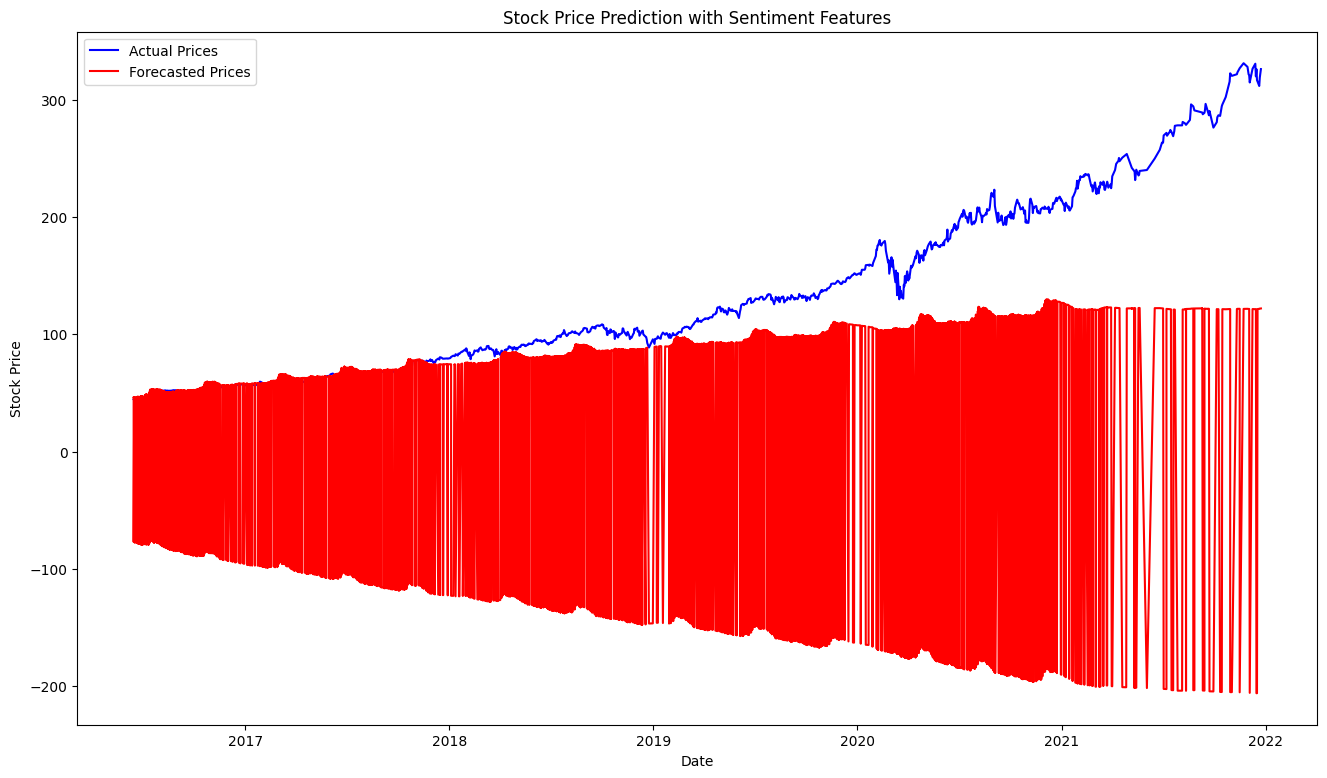

Cross-Validation Scores (Negative MSE): [ -14.17389009  -10.21572533  -22.16479695  -91.52108321 -404.23522385]
Mean Cross-Validation Score: -108.4621438854521


In [15]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

# ------------------------------
# Step 4: Load and Merge Stock and News Data
# ------------------------------
news_data = pd.read_csv('cleaned_business_news_with_vader.csv')
news_data['publish_date'] = pd.to_datetime(news_data['publish_date'], errors='coerce')

# ------------------------------
# Step 3: Preprocess Data and Feature Engineering
# ------------------------------
# Ensure compound_score has no NaN values
news_data['compound_score'] = news_data['compound_score'].fillna(0)

# Merge stock and news data on date
merged_data = pd.merge(stock_data_msft, news_data, left_on='Date', right_on='publish_date', how='inner')

# Add lagged sentiment features
merged_data['compound_score_lag1'] = merged_data['compound_score'].shift(1)
merged_data['compound_score_lag2'] = merged_data['compound_score'].shift(2)

# Fill NaN values in lagged sentiment features
merged_data[['compound_score_lag1', 'compound_score_lag2']] = merged_data[['compound_score_lag1', 'compound_score_lag2']].fillna(0)

# Prepare data for Prophet model
prophet_data = merged_data[['Date', 'Close', 'compound_score', 'compound_score_lag1', 'compound_score_lag2']].rename(
    columns={'Date': 'ds', 'Close': 'y'}
)

# Split into train and test
train_size = int(len(prophet_data) * 0.8)
train_data = prophet_data.iloc[:train_size]
test_data = prophet_data.iloc[train_size:]

# ------------------------------
# Step 4: Feature Scaling
# ------------------------------
# Use StandardScaler to scale the features
scaler = StandardScaler()

# Apply scaling to the features (compound_score, compound_score_lag1, compound_score_lag2)
train_data_scaled = train_data.copy()
test_data_scaled = test_data.copy()

train_data_scaled[['compound_score', 'compound_score_lag1', 'compound_score_lag2']] = scaler.fit_transform(
    train_data[['compound_score', 'compound_score_lag1', 'compound_score_lag2']]
)
test_data_scaled[['compound_score', 'compound_score_lag1', 'compound_score_lag2']] = scaler.transform(
    test_data[['compound_score', 'compound_score_lag1', 'compound_score_lag2']]
)

# ------------------------------
# Step 5: Prophet Model with Sentiment Features
# ------------------------------
# Initialize Prophet model
model_with_sentiment = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.05)

# Add sentiment as regressors
model_with_sentiment.add_regressor('compound_score')
model_with_sentiment.add_regressor('compound_score_lag1')
model_with_sentiment.add_regressor('compound_score_lag2')

# Fit the model
model_with_sentiment.fit(train_data_scaled)

# Forecasting
future = model_with_sentiment.make_future_dataframe(periods=len(test_data_scaled))
future = pd.merge(future, train_data_scaled[['ds', 'compound_score', 'compound_score_lag1', 'compound_score_lag2']], on='ds', how='left')

# Ensure no NaN values in future data
future[['compound_score', 'compound_score_lag1', 'compound_score_lag2']] = future[['compound_score', 'compound_score_lag1', 'compound_score_lag2']].fillna(0)

forecast = model_with_sentiment.predict(future)

# Evaluate performance
mse_with_sentiment = mean_squared_error(test_data_scaled['y'], forecast['yhat'][-len(test_data_scaled):])
mae_with_sentiment = mean_absolute_error(test_data_scaled['y'], forecast['yhat'][-len(test_data_scaled):])

print(f"MSE with Sentiment: {mse_with_sentiment}")
print(f"MAE with Sentiment: {mae_with_sentiment}")

# Visualization
plt.figure(figsize=(16, 9))
plt.plot(test_data_scaled['ds'], test_data_scaled['y'], label='Actual Prices', color='blue')
plt.plot(test_data_scaled['ds'], forecast['yhat'][-len(test_data_scaled):], label='Forecasted Prices', color='red')
plt.title("Stock Price Prediction with Sentiment Features")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# ------------------------------
# Step 6: Cross-Validation with TimeSeriesSplit
# ------------------------------
# TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# XGBoost model for comparison
xgb_model = xgb.XGBRegressor()

# Cross-validation using TimeSeriesSplit
cross_val_scores = cross_val_score(xgb_model, train_data_scaled[['compound_score', 'compound_score_lag1', 'compound_score_lag2']], 
                                   train_data_scaled['y'], cv=tscv, scoring='neg_mean_squared_error')

print("Cross-Validation Scores (Negative MSE):", cross_val_scores)
print("Mean Cross-Validation Score:", cross_val_scores.mean())


XGBoost MSE: 11764.101396302283
XGBoost MAE: 90.74971171054884
Random Forest MSE: 11768.537183610033
Random Forest MAE: 90.64905590716612
Gradient Boosting MSE: 11761.453907747476
Gradient Boosting MAE: 90.68666868106305


15:27:09 - cmdstanpy - INFO - Chain [1] start processing
15:27:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model with Sentiment MSE: 18266.48084871151
Prophet Model with Sentiment MAE: 82.47154744116648


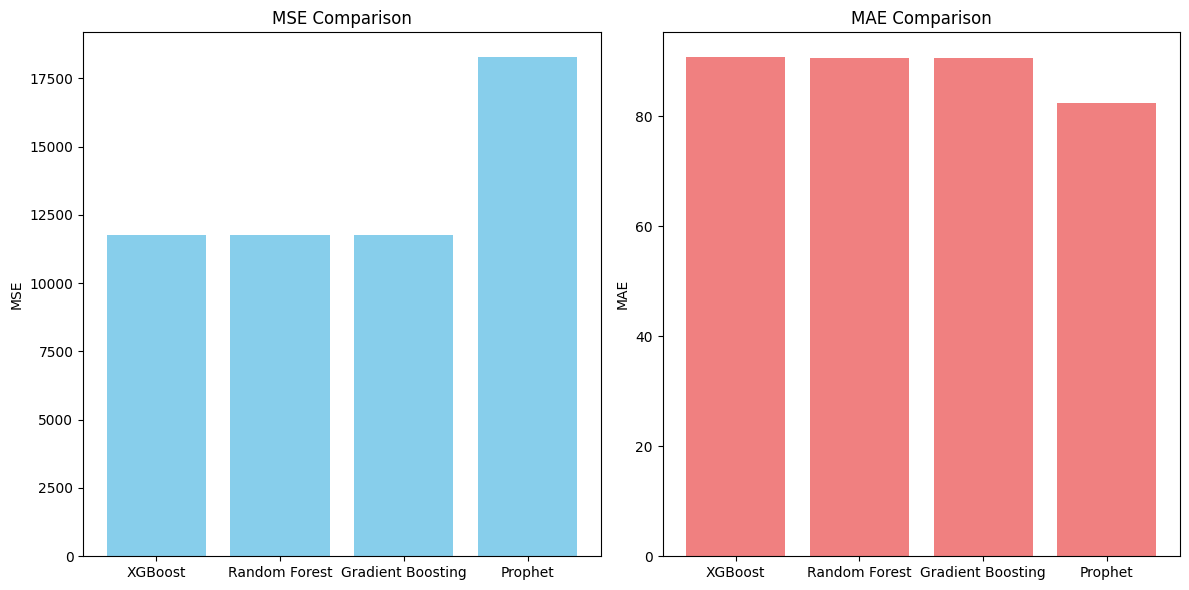

In [20]:
# ------------------------------
# Step 1: Import Required Libraries
# ------------------------------
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

# ------------------------------
# Step 3: Load and Merge Stock and News Data
# ------------------------------
news_data = pd.read_csv('cleaned_business_news_with_vader.csv')
news_data['publish_date'] = pd.to_datetime(news_data['publish_date'], errors='coerce')
news_data['compound_score'] = news_data['compound_score'].fillna(0)

# Merge stock data and news data
merged_data = pd.merge(stock_data_msft, news_data, left_on='Date', right_on='publish_date', how='inner')

# Add lagged sentiment features
merged_data['compound_score_lag1'] = merged_data['compound_score'].shift(1)
merged_data['compound_score_lag2'] = merged_data['compound_score'].shift(2)

# Fill NaN values after lagging
merged_data[['compound_score_lag1', 'compound_score_lag2']] = merged_data[['compound_score_lag1', 'compound_score_lag2']].fillna(0)

# Prepare the data for Prophet and other models
prophet_data = merged_data[['Date', 'Close', 'compound_score', 'compound_score_lag1', 'compound_score_lag2']].rename(
    columns={'Date': 'ds', 'Close': 'y'}
)

# Split into train and test
train_size = int(len(prophet_data) * 0.8)
train_data = prophet_data.iloc[:train_size]
test_data = prophet_data.iloc[train_size:]

# ------------------------------
# Step 4: Feature Scaling for XGBoost and Other Models
# ------------------------------
scaler = StandardScaler()
features = ['compound_score', 'compound_score_lag1', 'compound_score_lag2']
X = merged_data[features]
X_scaled = scaler.fit_transform(X)
y = merged_data['Close']

# Train-Test Split for machine learning models
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# ------------------------------
# Step 5: XGBoost Model
# ------------------------------
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=10)

# Train the model
xg_reg.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xg_reg.predict(X_test)

# Evaluate performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost MAE: {mae_xgb}")

# ------------------------------
# Step 6: Random Forest Model
# ------------------------------
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_reg.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_reg.predict(X_test)

# Evaluate performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest MAE: {mae_rf}")

# ------------------------------
# Step 7: Gradient Boosting Model
# ------------------------------
gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gb_reg.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_reg.predict(X_test)

# Evaluate performance
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print(f"Gradient Boosting MSE: {mse_gb}")
print(f"Gradient Boosting MAE: {mae_gb}")

# ------------------------------
# Step 8: Prophet Model with Sentiment Features
# ------------------------------
# Initialize Prophet model with sentiment features
model_with_sentiment = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.05)

# Add sentiment as regressors
model_with_sentiment.add_regressor('compound_score')
model_with_sentiment.add_regressor('compound_score_lag1')
model_with_sentiment.add_regressor('compound_score_lag2')

# Fit the model
model_with_sentiment.fit(train_data)

# Forecasting
future = model_with_sentiment.make_future_dataframe(periods=len(test_data))
future = pd.merge(future, prophet_data[['ds', 'compound_score', 'compound_score_lag1', 'compound_score_lag2']], on='ds', how='left')
# Ensure no NaN values in future data
future[['compound_score', 'compound_score_lag1', 'compound_score_lag2']] = future[['compound_score', 'compound_score_lag1', 'compound_score_lag2']].fillna(0)

forecast = model_with_sentiment.predict(future)

# Evaluate performance
mse_with_sentiment = mean_squared_error(test_data['y'], forecast['yhat'][-len(test_data):])
mae_with_sentiment = mean_absolute_error(test_data['y'], forecast['yhat'][-len(test_data):])

print(f"Prophet Model with Sentiment MSE: {mse_with_sentiment}")
print(f"Prophet Model with Sentiment MAE: {mae_with_sentiment}")

# ------------------------------
# Step 9: Compare All Models
# ------------------------------
models = ['XGBoost', 'Random Forest', 'Gradient Boosting', 'Prophet']
mse_values = [mse_xgb, mse_rf, mse_gb, mse_with_sentiment]
mae_values = [mae_xgb, mae_rf, mae_gb, mae_with_sentiment]

plt.figure(figsize=(12, 6))

# Plotting MSE
plt.subplot(1, 2, 1)
plt.bar(models, mse_values, color='skyblue')
plt.title('MSE Comparison')
plt.ylabel('MSE')

# Plotting MAE
plt.subplot(1, 2, 2)
plt.bar(models, mae_values, color='lightcoral')
plt.title('MAE Comparison')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()
